In [1]:
import numpy as np
import pandas as pd
import os
import glob
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import sys
from osgeo import gdal
import pickle
import matplotlib.pyplot as plt
from skimage import filters
from skimage import exposure

# Params

In [7]:
# General Params
TEST_CELL = 3738
BASE = '/mnt/poseidon/remotesensing/arctic/data'
OUT_DIR = f'{BASE}/rasters/model_results_tiled_test06'
DATA_DIR = f'{BASE}/rasters'
REF_RAST = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/B11/2019-06-01_to_2019-08-31/GRIDCELL_{TEST_CELL}.tif'
MODEL = f'{BASE}/training/Test_06/results/ModelTuning_FeatureImportance'
PFT_LIST = ['deciduous shrub', 'evergreen shrub', 'forb', 'graminoid', 'litter', 'non-vascular', 'lichen', 'bryophyte']

# Sensor-specific Params
S2_DIR = f'{DATA_DIR}/s2_sr_tiled/ak_arctic_summer/*/*'
S1_DIR = f'{DATA_DIR}/s1_grd_tiled'
DEM_DIR = f'{DATA_DIR}/acrtic_dem_tiled'

# Macander params
M_DIR = f'{BASE}/rasters/macander_2017'

# Definitions

In [36]:
def gridcell_rast_list(gridcell, directory):
    cell_band_paths = sorted(glob.glob(f'{directory}/GRIDCELL_{gridcell}*'))
    return cell_band_paths

In [46]:
# function to stack sensor bands for one gridcell
# will need to loop through each sensor and gridcell
def stack_bands(sensor, cell_num,
                resample_bands, ref_rast, scale_factor=None):
    
    """
    Creates an xarray with each band recorded as a variable.
    sensor         : [str] sensor source of data (s2_sr, s1_grd, or dem)
    cell_num       : [int] gridcell number to analyze
    resample_bands : [list] bands that need to be rescaled to 20-meters
    ref_rast       : [xr.Dataset] raster used as the model resolution/crs
    scale_factor   : [float or int] number multiplied to rescale data
    Returns an xr.Dataset with x,y,band dimensions for one gridcell with 
    each band as a data variable that matches the resolution/scale of the
    reference raster.
    """

    raster_bands = []
    for band_path in cell_num:

        # get band name from file path
        if sensor == 's2_sr':
            b_name = band_path.split('/')[-3]
        elif sensor == 'dem':
            b_name = band_path.split('/')[-1]
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        elif sensor == 's1_grd':
            b_name = band_path.split('/')[-1]
            b_name = b_name.split('.')[0]
            b_name = b_name.split('_')[-1]
        else:
            print('Incorrect sensor choice. Try dem, s2_sr, or s1_grd.')
        # print(f'Creating raster for {b_name}...')
        
        # open raster in xarray
        raster = rxr.open_rasterio(band_path)
        raster.name = b_name
        # print(raster.sizes, raster.dims)
        # raster.plot()
        # plt.show()
        
        # resample and rescale if necessary
        # print(f'Rescaling {b_name}...')
        raster = raster.rio.reproject_match(ref_rast)
        if scale_factor is not None:
            raster = raster * scale_factor
            
        # append to band list
        raster_bands.append(raster)

    merged = xr.merge(raster_bands)
    # drop pixel if any band is NA
    merged = merged.dropna(dim='band', how='any')
    return merged

In [47]:
def calc_veg_idx_s2(xrd):
    
    """
    Creates new data attributes for an s2_sr xr.Dataset with bands
    B2, B3, B4, B5, B6, B8, B8A, B11, and B12. Second step after 
    stack_bands. S2_sr data must be scaled from 0 to 1; can set
    scale factor in stack_bands function if necessary.
    xrd : [xr.Dataset] s2_sr xarray dataset
    Returns: xarray dataset with new vegetation indices
    """
    
    xrd = xrd.assign(ndwi1 = lambda x: (x.nir - x.swir1)/(x.nir + x.swir2))
    xrd = xrd.assign(ndwi2 = lambda x: (x.nir - x.swir2)/(x.nir + x.swir2))
    xrd = xrd.assign(msavi = lambda x: (2*x.nir + 1 -  ((2*x.nir + 1)**2 - 8*(x.nir - x.red))**0.5) * 0.5)
    xrd = xrd.assign(vari = lambda x: (x.green - x.red)/(x.green + x.red - x.blue))
    xrd = xrd.assign(rvi = lambda x: x.nir/x.red)
    xrd = xrd.assign(osavi = lambda x: 1.16 * (x.nir - x.red)/(x.nir + x.red + 0.16))
    xrd = xrd.assign(tgi = lambda x: (120 * (x.red - x.blue) - 190 * (x.red - x.green))*0.5)
    xrd = xrd.assign(gli = lambda x: (2 * x.green - x.red - x.blue)/(2 * x.green + x.red + x.blue))
    xrd = xrd.assign(ngrdi = lambda x: (x.green - x.red)/(x.green + x.red))
    xrd = xrd.assign(ci_g = lambda x: x.nir/x.green - 1)
    xrd = xrd.assign(gNDVI = lambda x: (x.nir - x.green)/(x.nir + x.green))
    xrd = xrd.assign(cvi = lambda x: (x.nir * x.red)/(x.green ** 2))
    xrd = xrd.assign(mtvi2 = lambda x: 1.5*(1.2*(x.nir - x.green) - 2.5*(x.red - x.green))/(((2*x.nir + 1)**2 - (6*x.nir - 5*(x.red**0.5))-0.5)**0.5))
    xrd = xrd.assign(brightness = lambda x: 0.3037 * x.blue +0.2793 * x.green +0.4743 * x.red +0.5585 * x.nir +0.5082 * x.swir1 + 0.1863 * x.swir2)
    xrd = xrd.assign(greenness = lambda x: 0.7243 * x.nir +0.0840 * x.swir1 - 0.2848 * x.blue - 0.2435 * x.green - 0.5436 * x.red - 0.1800 * x.swir2)
    xrd = xrd.assign(wetness = lambda x: 0.1509 * x.blue+0.1973* x.green+0.3279*x.red+0.3406*x.nir-0.7112*x.swir1 - 0.4572*x.swir2)
    xrd = xrd.assign(tcari = lambda x: 3 * ((x.redEdge1 - x.red)-0.2 * (x.redEdge1 - x.green)*(x.redEdge1/x.red)))
    xrd = xrd.assign(tci = lambda x: 1.2 * (x.redEdge1 - x.green)- 1.5 * (x.red - x.green)*((x.redEdge1/x.red)**0.5))
    xrd = xrd.assign(nari = lambda x: (1/x.green - 1/x.redEdge1)/(1/x.green + 1/x.redEdge1))

    return xrd

In [48]:
def exp_height_equation(x, a, b):
    return a * np.exp(b * x)

# Prep

In [49]:
# S2
rast_list = gridcell_rast_list(TEST_CELL, S2_DIR)
scale_factor = 0.0001
reference_raster = rxr.open_rasterio(REF_RAST) * scale_factor
rescale_bands = ['B2', 'B3', 'B4', 'B8']
s2 = stack_bands('s2_sr', rast_list, 
                 rescale_bands, reference_raster, 
                 scale_factor)

In [50]:
# rename bands to something legible
s2 = s2.rename({'B2':'blue', 'B3':'green', 
                'B4':'red', 'B5':'redEdge1', 
                'B6':'redEdge2', 'B7':'redEdge3', 
                'B8A':'redEdge4', 'B8':'nir',
                'B11':'swir1', 'B12':'swir2'})
# calculate vegetation indices
s2 = calc_veg_idx_s2(s2)

In [51]:
# S1
s1_rast_list = gridcell_rast_list(TEST_CELL, S1_DIR)
rescale_bands = ['VV', 'VH']
s1 = stack_bands('s1_grd', s1_rast_list,
                 rescale_bands, reference_raster)

In [27]:
# topo
dem_rast_list = gridcell_rast_list(TEST_CELL, DEM_DIR)
rescale_bands = ['aspect', 'dem', 'hillshade', 'slope']
dem_stacked_raster = stack_bands('dem', dem_rast_list[TEST_CELL_IDX], 
                                 rescale_bands, reference_raster)
dem_stacked_raster = dem_stacked_raster.rename({'dem':'elevation'})
rescale_bands2 = ['aspect', 'elevation', 'hillshade', 'slope']
dem_stacked_raster = dem_stacked_raster.where(dem_stacked_raster[rescale_bands2] != -9999., 0.)

Creating raster for dem...
Creating raster for aspect...
Creating raster for hillshade...
Creating raster for slope...


In [29]:
# merge and model
stacked_raster = xr.merge([stacked_raster_veg, 
                           s1_stacked_raster, 
                           dem_stacked_raster])

# get coords
df = stacked_raster.to_dataframe()
coords = df.reset_index()
coords = coords[['x', 'y']]

# clean
df = df.droplevel([1, 2]).reset_index(drop=True)
df = df.iloc[:,1:]
df = df.astype(np.float32)

# find any bands that were divided by 0 and produced an inf value
bad_idx_list = df[df.values == np.inf].index.tolist()
df.drop(index=bad_idx_list, inplace=True)
coords.drop(index=bad_idx_list, inplace=True)

# Maps

In [ ]:
for PFT in PFT_LIST:
    
    # Load the pickled model from the file
    model_file_path = f'{MODEL}/tunedModel_{PFT}.pkl'
    demo_df = pd.read_csv(f'{MODEL}/FeatureDemo_non-vascular.csv', index_col=0)
    col_order = demo_df.columns.tolist()
    df = df[col_order]
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)

    # --- prediction directly used the model
    fCover = model.predict(df) # fCover is a 1 by n
    print(fCover.shape)
    print(fCover)
    
    # create dataframe
    results = coords.copy()
    results['fcover'] = fCover
    results['band'] = 1
    
    # create xarray and plot
    results_xr = xr.Dataset.from_dataframe(results.set_index(['band', 'y', 'x']))
    results_xr.fcover.plot(cmap='Greens')
    plt.title(f'{PFT} fcover')
    plt.show()

Text(0.5, 1.0, 'Gridcell 3738 RGB')

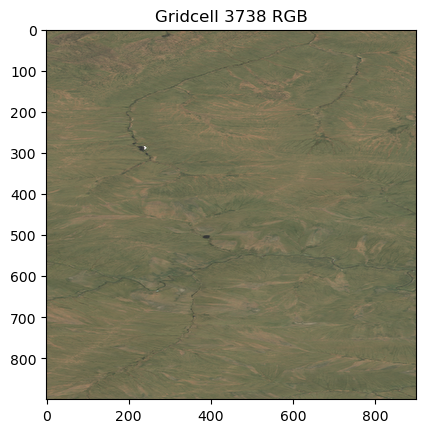

In [21]:
def adjust_brightness(image, factor):
    adjusted_image = np.clip(image * factor, 0, 1)  # Clip values to [0, 1]
    return adjusted_image
rgb = np.dstack((rast.isel(band=0).red.to_numpy(),
                 rast.isel(band=0).green.to_numpy(),
                 rast.isel(band=0).blue.to_numpy()))
b_rgb = adjust_brightness(rgb, 5)
plt.imshow(b_rgb, alpha=0.8, interpolation = 'sinc')
plt.title(f'Gridcell {TEST_CELL} RGB')